<a href="https://colab.research.google.com/github/LeonardoMarquesLeme/Product-Owners-Skills-Analytics-Python/blob/main/Product_Owners_Skills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# ANÁLISE DE SKILLS DOS POs
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import display
upload = files.upload()


Saving case_assessmentAnalytics (2).xlsx to case_assessmentAnalytics (2) (4).xlsx


In [ ]:
# 1. Ler as abas do Excel
arquivo = 'case_assessmentAnalytics (2).xlsx'  # altere se o nome for diferente
base = pd.read_excel(arquivo, sheet_name='Base_Avaliacao')
nivel = pd.read_excel(arquivo, sheet_name='Nivel_de_necessidade_po')
len(base)

283

In [ ]:
# 2. Definir as skills (colunas de nota)
skills = ['[Contexto estratégico]', '[Problem solving]', '[Atitude de dono]',
          '[Poder de influência]', '[Produto como plataforma]', '[Mindset lean e ágil]',
          '[Product discovery]', '[Negócio e indústria]', '[P&L]', '[Dados]']

In [ ]:
# 3. Criando filtro para manter somente POs
mask_po = base['Papel_comunidade']=='PO' # Filtrando por papel na comunidade
# 3.1 Criando filtro para desconsiderar especialidade Tecnologia
mask_tecnologia = base['ESPECIALIDADE_avaliado'] != 'TECNOLOGIA'
# 3.2 Filtrando
mask_final = (mask_po & mask_tecnologia)
base = base[mask_final]

len(base)

153

In [ ]:
# 4. Agrupando por colaborador e especialidade e calculando a média (na base ha mais de uma avaliacao por colaborador)
media_colab = base.groupby(['Nome do colaborador avaliado', 'ESPECIALIDADE_avaliado'])[skills].mean().reset_index()
len(media_colab)

79

In [ ]:
# 5. Juntar com o nível esperado (usando a especialidade)
dados = pd.merge(media_colab, nivel, left_on='ESPECIALIDADE_avaliado', right_on='ESPECIALIDADE', suffixes=('_atual', '_esperado'), how = 'left')


In [ ]:
# 6. Calcular o gap (diferença entre atual e esperado)
for skill in skills:
    dados[f'Gap_{skill}'] = dados[f'{skill}_atual'] - dados[f'{skill}_esperado']

In [ ]:
# 7. Gap médio por skill (para identificar principais lacunas)
gap_skill = dados[[f'Gap_{s}' for s in skills]].mean().sort_values()

In [ ]:
# 8. Porcentagem de POs aptos (todos gaps >= 0)
dados['Apto'] = dados[[f'Gap_{s}' for s in skills]].apply(lambda x: all(x >= 0), axis=1)
porcentagem_aptos = dados['Apto'].mean() * 100

In [ ]:
# Contagem absoluta
contagem = dados['Apto'].value_counts()

# Porcentagem (em %)
porcentagem = dados['Apto'].value_counts(normalize=True) * 100

# Junta em uma única tabela
tabela = pd.DataFrame({
    'Contagem': contagem,
    'Percentual (%)': porcentagem.round(1)
}).reset_index()

# Renomeia coluna para clareza
tabela.rename(columns={'index': 'Apto'}, inplace=True)
display(tabela)

,Apto,Contagem,Percentual (%)
0,False,72,91.1
1,True,7,8.9


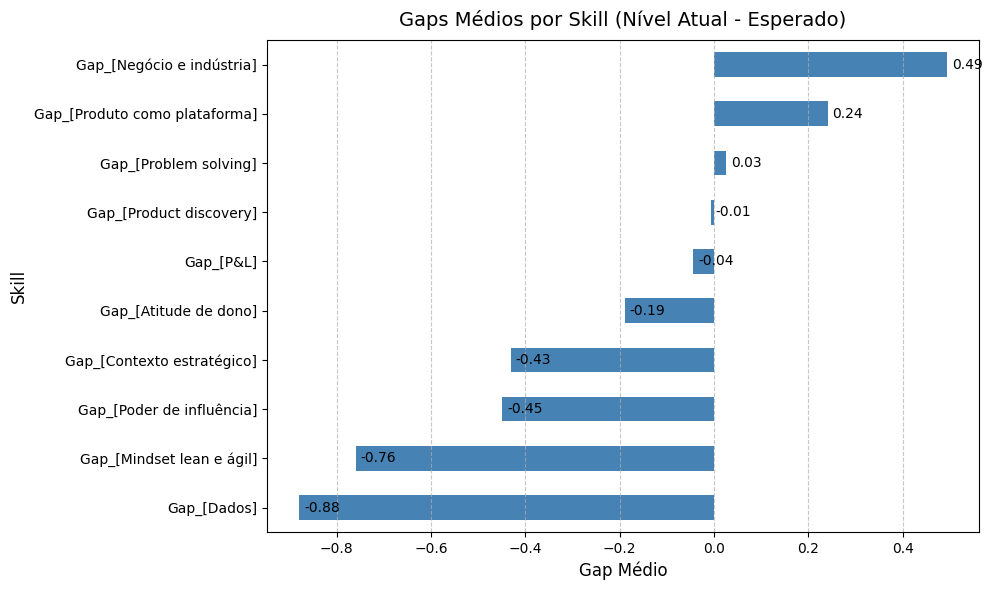

In [ ]:

# 9. Criar gráfico dos gaps médios com rótulos
plt.figure(figsize=(10,6))
ax = gap_skill.plot(kind='barh', color='steelblue')

plt.title('Gaps Médios por Skill (Nível Atual - Esperado)', fontsize=14, pad=10)
plt.xlabel('Gap Médio', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adiciona os rótulos de valor ao lado de cada barra
for i, v in enumerate(gap_skill):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()




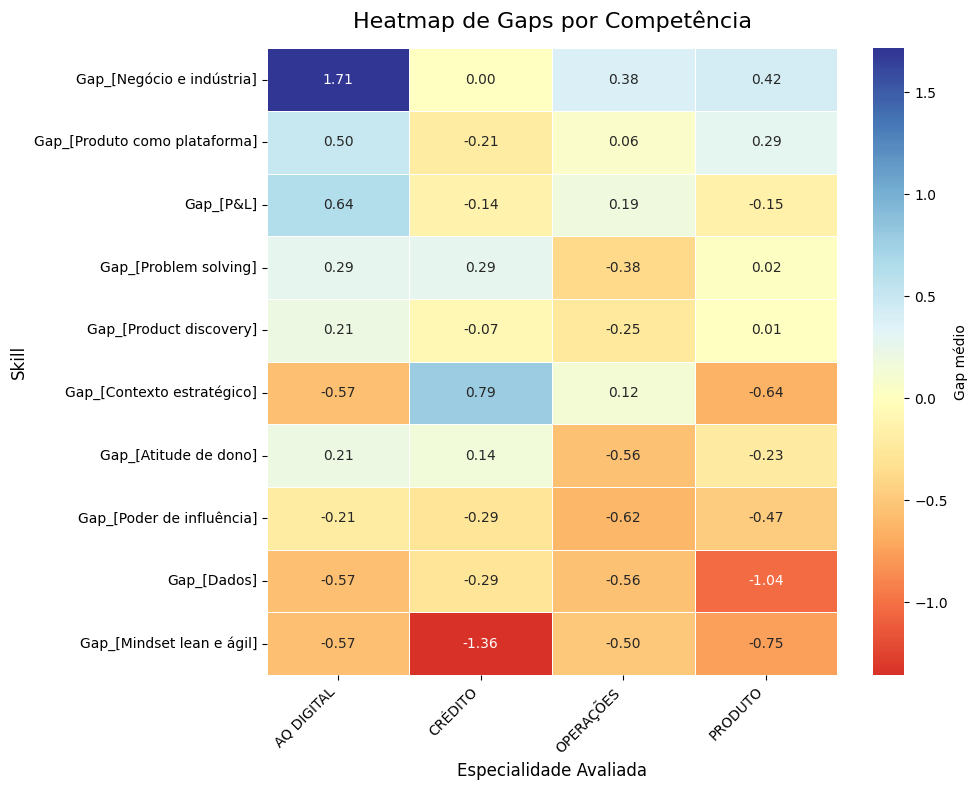

In [ ]:
# 11. Gap médio por especialidade e skill (para identificar principais lacunas)
lista_campos_groupby = ['ESPECIALIDADE_avaliado']
gap_skill_especialidade = dados.groupby(lista_campos_groupby)[[f'Gap_{s}' for s in skills]].mean()

df = gap_skill_especialidade.T.copy()

# Calcula a média por competência (linha)
df["Média"] = df.mean(axis=1)

# Ordena do pior (menor média) para o melhor (maior média)
df = df.sort_values(by="Média", ascending=False)

# Remove a coluna "Média" antes de plotar
df_plot = df.drop(columns=["Média"])

# Plot do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_plot,
    annot=True,
    fmt=".2f",
    cmap="RdYlBu",           # vermelho = menor valor, azul = maior valor
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Gap médio'}
)

plt.title("Heatmap de Gaps por Competência", fontsize=16, pad=15)
plt.xlabel("Especialidade Avaliada", fontsize=12)
plt.ylabel("Skill", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()